In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


In [2]:

# Load your stock price data into a DataFrame
# Replace 'your_data.csv' with the path to your data file
data = pd.read_excel('/kaggle/input/data-sets/final_data_with_covid_same.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)


In [4]:
# Dataset
#data.index.freq="QS-OCT" #Quarterly Starting in Octomber (was in tutorial)

data['ln_close'] = np.log(data['Close'])
data['D.ln_close'] = data['ln_close'].diff()


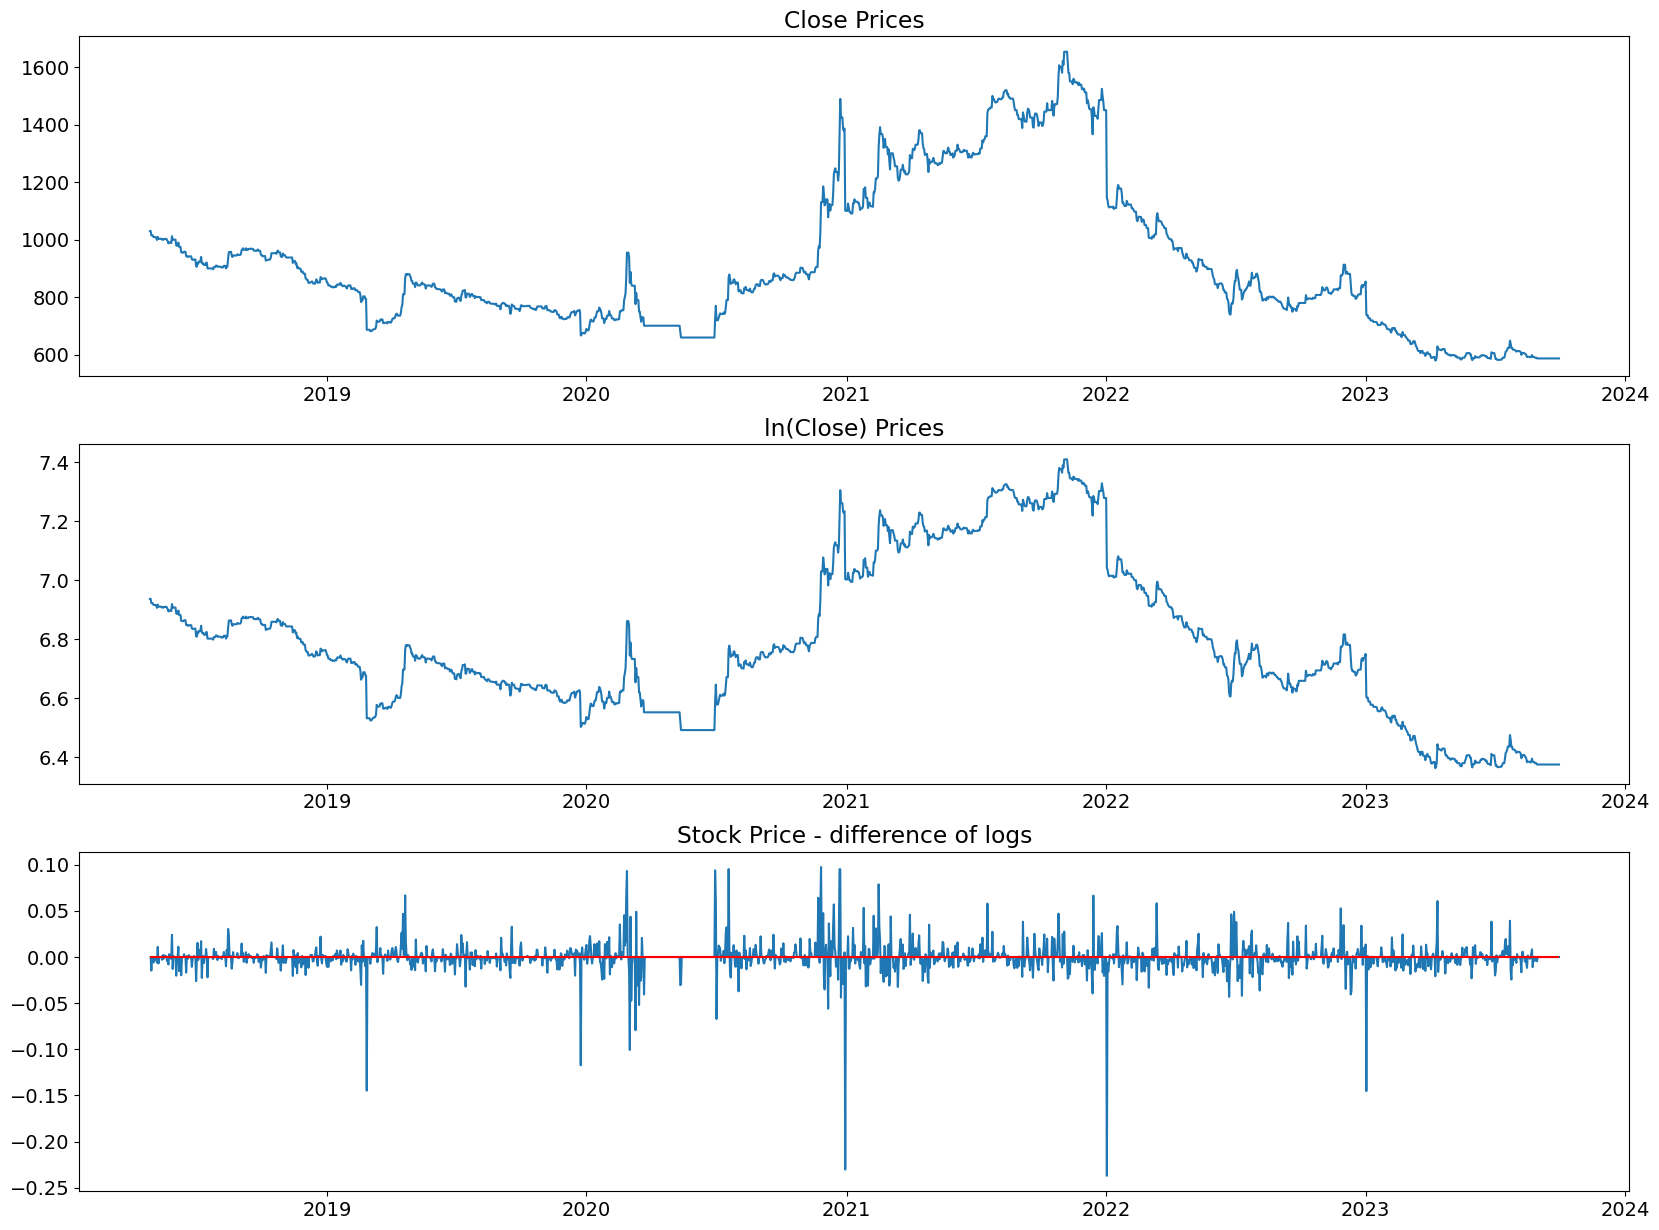

In [5]:
# Graph data
fig, axes = plt.subplots(3, 1, figsize=(20,15))

# Levels
axes[0].plot(data.index._mpl_repr(), data['Close'], '-')
axes[0].set(title='Close Prices')


axes[1].plot(data.index._mpl_repr(), data['ln_close'], '-')
axes[1].set(title='ln(Close) Prices')

# Log difference
axes[2].plot(data.index._mpl_repr(), data['D.ln_close'], '-')
axes[2].hlines(0, data.index[0], data.index[-1], 'r')
axes[2].set(title='Stock Price - difference of logs');


As seen also during the ARIMA analysis, the data is non-stationary.

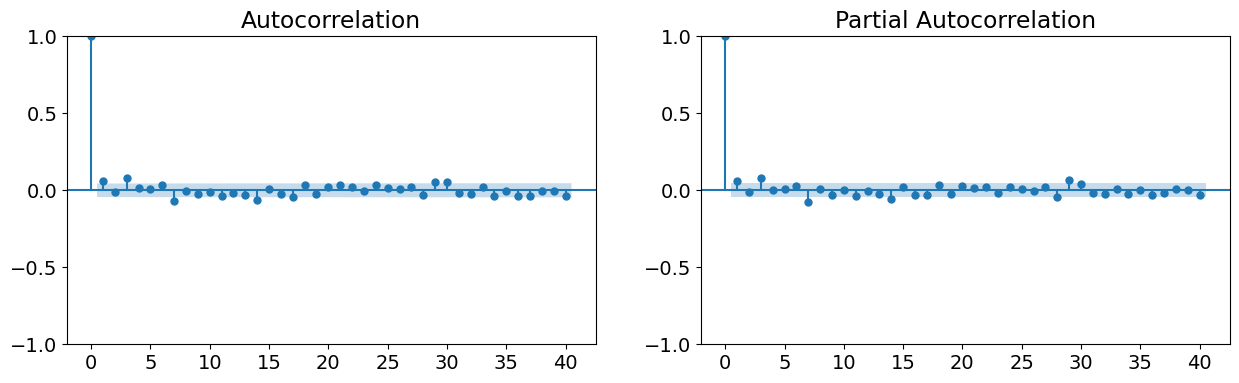

In [6]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_close'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_close'], lags=40, ax=axes[1])


In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Define the columns  to use as exogenous features
exog_cols = ['EPS', 'Book Value', 'COF', 'Dividend', 'inflation', 'Remittance Growth Rate(%)',
             'Open', 'High', 'Low', 'Volume', 'MA_10', 'Bollinger_Middle',
             'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal_Line', 'MA_30', 'Compound Sensitivity']

# Define the target variable
target_col = 'Close'


endo = data[target_col]
exog = data[exog_cols]

In [9]:
mod = sm.tsa.statespace.SARIMAX(data['Close'], order=(2,1,0), seasonal_order=(1,1,0,12))
res=mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1983
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -8689.920
Date:                            Sat, 21 Oct 2023   AIC                          17387.840
Time:                                    09:08:45   BIC                          17410.183
Sample:                                04-27-2018   HQIC                         17396.050
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0700      0.016      4.436      0.000       0.039       0.101
ar.L2         -0.0146      0.017   

## PostEstimation


## 1 Dynamic Forecasting

First, using the model from example, we estimate the parameters using data that excludes the last few observations (this is a little artificial as an example, but it allows considering performance of out-of-sample forecasting 

In [10]:
# Dataset
nobs = endo.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endo.loc[:'2023-05-01'], exog=exog.loc[:'2023-05-01'], order=(1,0,1), seasonal_order=(0,1,0,12))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1831
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood               -6495.714
Date:                             Sat, 21 Oct 2023   AIC                          13033.428
Time:                                     09:08:59   BIC                          13149.055
Sample:                                 04-27-2018   HQIC                         13076.088
                                      - 05-01-2023                                         
Covariance Type:                               opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
EPS                           0.0195      0.077      0.255      0.799      -

Next, we want to get results for the full dataset but using the estimated parameters (on a subset of the data).

In [11]:
mod = sm.tsa.statespace.SARIMAX(endo, exog, order=(1,0,1), seasonal_order=(0,1,0,12))
#fit_res from the trained on subset
res = mod.filter(fit_res.params)


## In-sample one-step-ahead predictions


In [12]:
predict = res.get_prediction()
predict_ci = predict.conf_int()


We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

The dynamic argument is specified to be an offset relative to the start argument. If start is not specified, it is assumed to be 0.

2023-01

In [13]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2023-01-01')
predict_dy_ci = predict_dy.conf_int()


We can graph the one-step-ahead and dynamic predictions (and the corresponding confidence intervals) to see their relative performance. Notice that up to the point where dynamic prediction begins (1978:Q1), the two are the same.

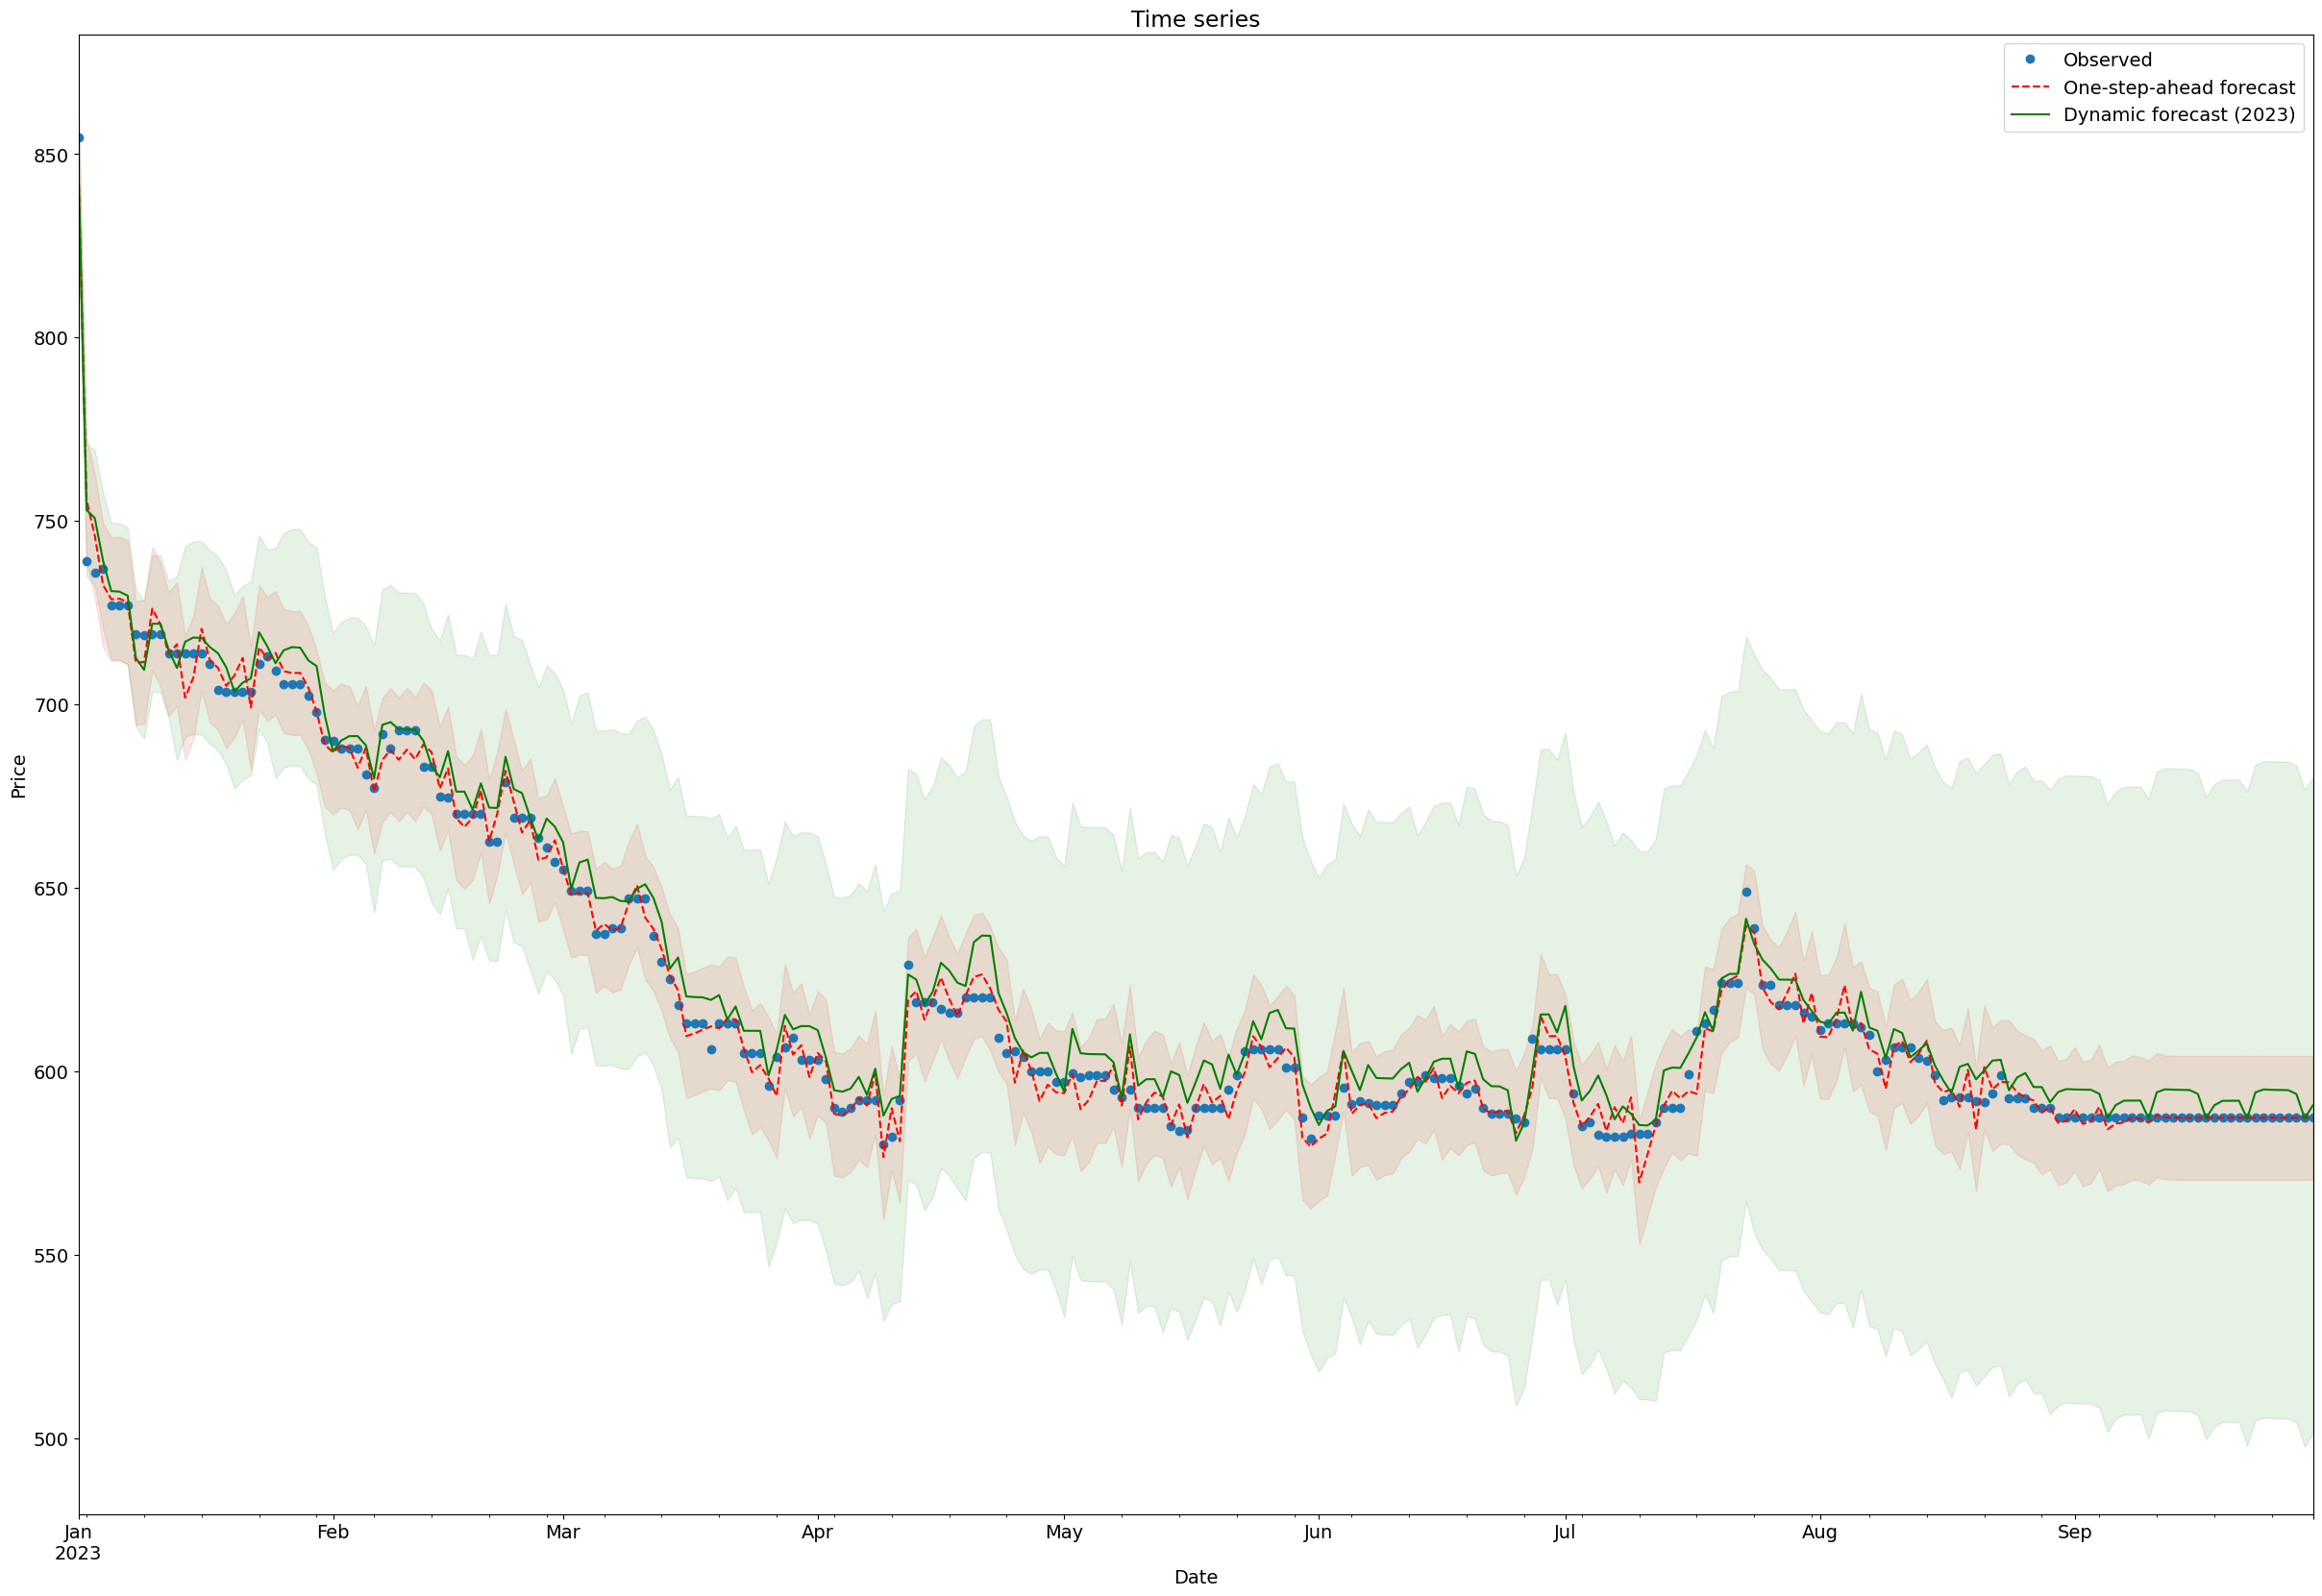

In [14]:
# Graph
fig, ax = plt.subplots(figsize=(30,20))
npre = 4
ax.set(title='Time series', xlabel='Date', ylabel='Price')

# Plot data points
data.loc['2023-01-01':, 'Close'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2023-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2023-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2023-01-01':].plot(ax=ax, style='g', label='Dynamic forecast (2023)')
ci = predict_dy_ci.loc['2023-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend()


Finally, graph the prediction error. It is obvious that, as one would suspect, one-step-ahead prediction is considerably better.

NameError: name 'endog' is not defined

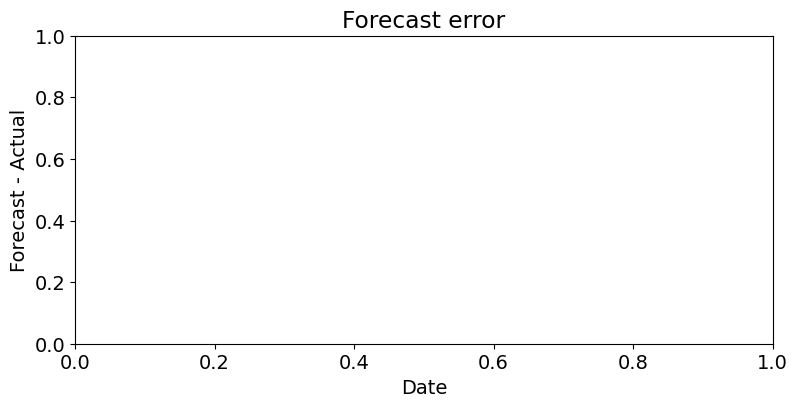

In [15]:
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - endog
predict_error.loc['2023-01-01':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc['2023-01-01':].copy()
ci.iloc[:,0] -= endog.loc['2023-01-01':]
ci.iloc[:,1] -= endog.loc['2023-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - endog
predict_dy_error.loc['2023-01-01':].plot(ax=ax, style='r', label='Dynamic forecast (2023)')
ci = predict_dy_ci.loc['2023-01-01':].copy()
ci.iloc[:,0] -= endog.loc['2023-01-01':]
ci.iloc[:,1] -= endog.loc['2023-01-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend();
legend.get_frame().set_facecolor('w')


In [ ]:
np.sum(np.power(predict_error,2))/len(predict_error)